In [1]:
!git clone https://github.com/Mukundanks/Comp-702.git

Cloning into 'Comp-702'...
remote: Enumerating objects: 5587, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 5587 (delta 1), reused 12 (delta 0), pack-reused 5562
Receiving objects: 100% (5587/5587), 1.06 GiB | 13.39 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import cv2
import matplotlib.pyplot as plt
from os.path import isfile
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import os
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
import time
from torch.autograd import Variable
import torch.functional as F
import torch.optim as optim
from tqdm import tqdm
from sklearn import metrics
import urllib
import pickle
import cv2
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torchvision import models
import seaborn as sns
import random
import sys
import gc

In [3]:
train      = '../input/aptos2019-blindness-detection/test_images/'
len(train)
test       = '../input/aptos2019-blindness-detection/train_images/'
train_csv  = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_csv  = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
train_df, val_df = train_test_split(train_csv, test_size=0.1, random_state=2018, stratify=train_csv.diagnosis)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df.head()

,id_code,diagnosis
0,1f5496352859,0
1,82e5bc01f8a4,0
2,fbdc796290d4,0
3,7adfb8fc0621,0
4,e26d8718ca58,1


In [4]:
!nvidia-smi

Sun Oct 23 22:53:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [5]:
def expand_path(p):
    p = str(p)
    if isfile(train + p + ".png"):
        return train + (p + ".png")
    
    if isfile(test + p + ".png"):
        return test + (p + ".png")
    return p

In [6]:
def p_show(imgs, label_name=None, per_row=3):
    n = len(imgs)
    rows = (n + per_row - 1)//per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(15,15))
    for ax in axes.flatten(): ax.axis('off')
    for i,(p, ax) in enumerate(zip(imgs, axes.flatten())): 
        img = Image.open(expand_path(p))
        ax.imshow(img)
        ax.set_title(train_df[train_df.id_code == p].diagnosis.values)

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


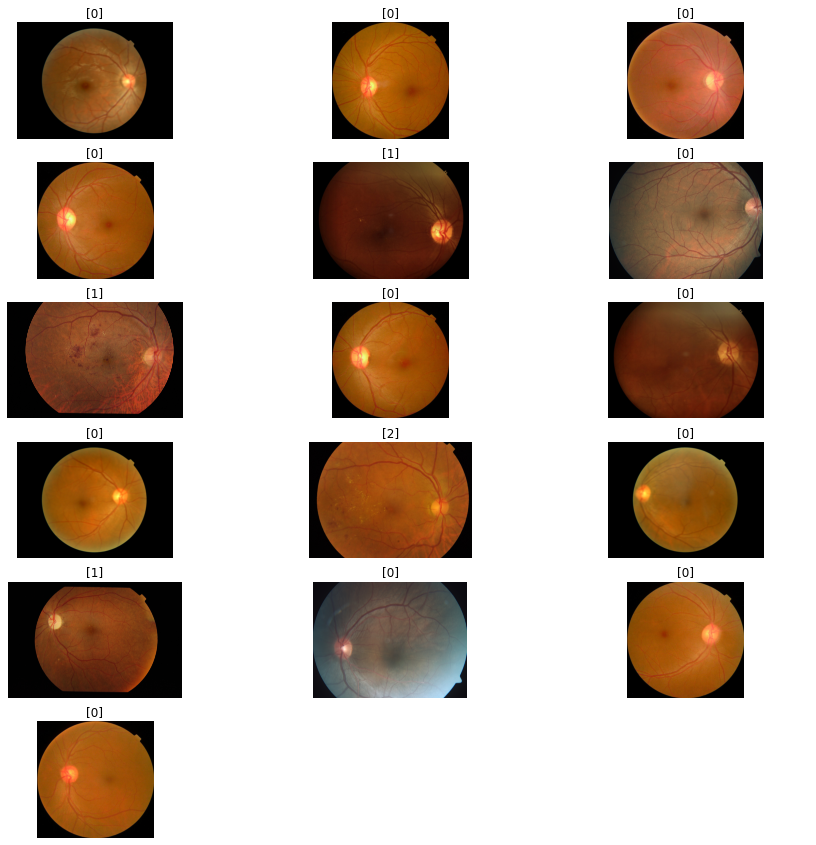

In [7]:
imgs = []
for p in train_df.id_code:
    imgs.append(p)
    if len(imgs) == 16: break
p_show(imgs)

In [8]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [9]:
IMG_SIZE = 90
LR = 1e-4
BATCH_SIZE = 5
EPOCHS = 20

In [10]:
class MyDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        label = self.df.diagnosis.values[idx]
        label = np.expand_dims(label, -1)
        
        p = self.df.id_code.values[idx]
        p_path = expand_path(p)
        image = cv2.imread(p_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_image_from_gray(image)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 30) ,-4 ,128)
        image = transforms.ToPILImage()(image)
        
        if self.transform:
            image = self.transform(image)
        
        image = np.resize(image, (3,IMG_SIZE, IMG_SIZE))
        image = torch.tensor(image)
        label = torch.tensor(label)
        
        return image, label

In [11]:
class MyDataset1(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        p = self.df.id_code.values[idx]
        p_path = expand_path(p)
        image = cv2.imread(p_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_image_from_gray(image)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 30) ,-4 ,128)
        image = transforms.ToPILImage()(image)
        
        if self.transform:
            image = self.transform(image)
        
        image = np.resize(image, (3,IMG_SIZE, IMG_SIZE))
        image = torch.tensor(image)
     
        
        return image

In [12]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset     = MyDataset(train_df, transform =train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=4)
valset       = MyDataset(val_df, transform   =train_transform)
val_loader   = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
test_transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
testset       = MyDataset1(test_csv, transform   =test_transform)
test_loader   = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)

In [14]:
X, y = next(iter(train_loader))

In [15]:
X.shape

torch.Size([1, 3, 90, 90])

In [16]:
z= next(iter(test_loader))

In [17]:
z.shape

torch.Size([1, 3, 90, 90])

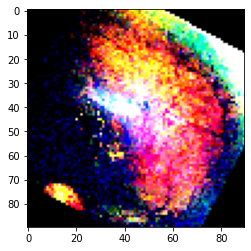

In [18]:
plt.imshow(z.squeeze(0).permute(1,2,0))

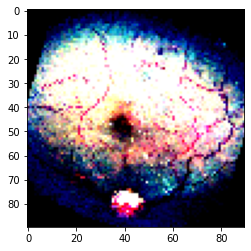

In [19]:
plt.imshow(X.squeeze(0).permute(1,2,0))

In [20]:
model = models.resnet34(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)

In [22]:
model.fc = nn.Sequential(nn.Linear(512,256),
                         nn.ReLU(inplace=True),
                         nn.Linear(256,128),
                         nn.ReLU(inplace=True),
                         nn.Linear(128,64),
                         nn.ReLU(inplace=True),
                         nn.Linear(64,5),    
                    )

In [23]:
def one_hot(logits, y, device= device):
  a = np.zeros_like(logits.squeeze(0).detach().cpu().numpy())
  a[y.item()] = 1
  o_hot = torch.tensor(a).unsqueeze(0).to(device)
  return o_hot

In [24]:
optimizer = Adam(model.parameters(), lr=1e-2)
loss = 'NLLLoss'
loss_fn = nn.CrossEntropyLoss()

In [25]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# train_accuracy = 0
# val_accuracy = 0
best_accuracy = 0
running_loss = 0
accuracy = 0
n_epochs = 1
for epoch in range(1, n_epochs+1):
    total = 0
    with tqdm(train_loader, unit="iteration") as train_epoch:
        train_epoch.set_description(f"Epoch {epoch}")
        for i, (data, target) in enumerate(train_epoch):
            total_samples = len(train_loader.dataset)
            #device
            model = model.to(device)
            x = data.to(device)
            target = target.to(device)
            logits = model(x)
            y = one_hot(logits, target)
            
            optimizer.zero_grad()

            
            loss = loss_fn(logits, y)
            loss.backward()           
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            l = running_loss / len(train_loader)

            _, proba = torch.max(nn.Softmax(dim=0)(logits), dim=0)
            accuracy += torch.sum(proba == y).float().item()
            a = (accuracy/len(train_loader))*100

            train_epoch.set_postfix(loss=l, accuracy=a)

            if a > best_accuracy:
              best_accuracy = a
              best_model = model
              #torch.save(best_model, "./")


Epoch 1: 100%|██████████| 3295/3295 [10:42<00:00,  5.13iteration/s, accuracy=400, loss=1.34]


In [27]:
def test(dataloader,model):
    '''
    test function predicts the labels given an image batches.
    
    Args :
         dataloader: DataLoader for the test_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         
    Returns :
         List of predicted labels.
    '''
     
    model.eval() #Sets the model for evaluation.
    
    labels = [] #List to store the predicted labels.
    
    with torch.no_grad():
        
        for batch,(x) in enumerate(dataloader):
            x = x.to(device)
            output = model(x)
            
            predictions = output.argmax(dim=1).cpu().detach().tolist() #Predicted labels for an image batch.
            labels.extend(predictions)
                
    print('Testing has completed')
            
    return labels                


In [28]:
test(test_loader,model)

Testing has completed


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [29]:
predict = []
model.eval()
for i, (data) in enumerate(test_loader):
    data = data.cuda()
    output = model(data)  
    output = output.cpu().detach().numpy()    
    predict.append(output[0])

In [30]:
submit=test_csv.copy()

In [31]:
submit['diagnosis'] = np.argmax(predict, axis=1)
submit.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0
